In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

np.random.seed(0)

## Generate data, Estimators

In [3]:
# params
p = 200
c1 = 90
c2 = 300
n1 = c1 * p
n2 = c2 * p
sigma = 4

# covariates
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)
hat_beta_t = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2

def te_target(X1, X2, beta_s, beta_t, w, sigma_2 = sigma, Sigma2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma_2**2 * np.trace(K @ Sigma2_sqrt @ Sigma2_sqrt)
    model_shift_bias = w**2 * np.linalg.norm(Sigma2_sqrt @ K @ X1.T @ X1 @ beta_diff) **2
    return model_shift_bias + var

def mtl_target(X1, X2, beta_s, beta_t, w, n1, n2, Sigma_1_sqrt = np.eye(p), Sigma_2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma**2 * (n1 + n2) * np.trace(K)
    model_shift_bias = n1 * (np.linalg.norm(K @ X2.T @ X2 @ beta_diff) ** 2)
    model_shift_bias += n2 * w**2 * (np.linalg.norm(K @ X1.T @ X1 @ beta_diff) ** 2)
    return (model_shift_bias + var) / (n1 + n2)

## Find optimal w

In [4]:
def opt_w_val(X1, X2, beta_s, beta_t, n1, n2, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f_val(w):
        return mtl_target(X1, X2, beta_s, beta_t, w, n1, n2)
    
    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f_val, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
    
    plt.figure(c)
    plt.plot(x_list, fun_list)
    
    return x_list[np.argmin(fun_list)]

def opt_w(X1, X2, beta_s, beta_t, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f(w):
        return te_target(X1, X2, beta_s, beta_t, w)

    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
        
    plt.figure(c)
    plt.plot(x_list, fun_list)
        
    return x_list[np.argmin(fun_list)]

In [5]:
#sigma = 4
#c2 = 500
#print(sigma, c2)

#d = 0.02
#threshold_ex = sigma**2 / (p * d**2 - sigma**2 / c2)

#print('is negative when c1 is large', c2 > threshold_ex)

#print(threshold_ex)
#c1 = 200
#lb = sigma**2 / (p * d**2 * (1 + 1.0 / math.sqrt(c1))**4 - sigma**2 / c2)
#print(lb)

#c1 = 500
#ub = sigma**2 / (p * d**2 * (1 - 1.0 / math.sqrt(c1))**4 - sigma**2 / c2)
#print(ub)

## Test errors and transfer

In [6]:
def test_errors_and_transfer(c1, d):
    beta_s = beta_t + d * np.random.randn(p, 1)
    n1 = c1 * p
    X1 = np.random.randn(n1, p)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    te_beta_t = te_target(X1, X2, beta_t, beta_t, 0)

    w_hat = opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
    te_beta_st = te_target(X1, X2, beta_s, beta_t, w_hat)
    print('Test error:', 'STL', te_beta_t, 'MTL', te_beta_st, 'OPT_W', w_hat)

    if te_beta_st < te_beta_t:
        print('Positive transfer')
    else:
        print('Negative transfer')
        
    delta_beta = p * ((1 - w_hat)**2 + d**2) * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    print(delta_var, delta_beta, delta_var / delta_beta)

    if delta_var / delta_beta >= deviation_ub:
        print('Provably positive')
    elif delta_var / delta_beta <= deviation_lb:
        print('Provably negative')

    print(deviation_lb, deviation_ub)

#d = 0.02
#c1 = 50
#test_errors_and_transfer(c1, d)

#c1 = 500
#test_errors_and_transfer(c1, d)

## Plot the effect of task distance

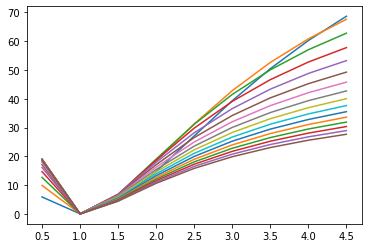

In [7]:
d = 0.02
c1_list = [50 * i for i in range(1, 17)]
te_mtl_list = []

provable_pos = [[], []]
provable_neg = [[], []]
unknown = [[], []]

beta_s = beta_t + d * np.random.randn(p, 1)

for c1 in c1_list:
    n1 = c1 * p
    X1 = np.random.randn(n1, p)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    #hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)
    hat_w = opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
    te_beta_st = te_target(X1, X2, beta_s, beta_t, hat_w)
    
    #te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2
    te_mtl_list.append(te_beta_st)

    delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_beta = ((1 - hat_w)**2 + d**2) * delta_beta_base
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    if delta_var / delta_beta > deviation_ub:
        provable_pos[0].append(c1)
        provable_pos[1].append(te_beta_st)
    elif delta_var / delta_beta < deviation_lb:    
        provable_neg[0].append(c1)
        provable_neg[1].append(te_beta_st)
    else:
        unknown[0].append(c1)
        unknown[1].append(te_beta_st)

In [8]:
print(c1_list)
estimate_list = [p*d**2 * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3 + sigma**2 / (c1 + c2 - 1) for c1 in c1_list]

print(te_mtl_list)
print(np.array(estimate_list))

print(np.array(te_mtl_list) - np.array(estimate_list))


[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
[0.04741209062124011, 0.04484380566175636, 0.04376308248461844, 0.04378446565714049, 0.044190678468305836, 0.04506054967374021, 0.04594390955846368, 0.0468761027492252, 0.047982856052923586, 0.04870594465943576, 0.049705065393276474, 0.05035139180418735, 0.05139124142597578, 0.052150430939609894, 0.05278819149398675, 0.053404887020570224]
[0.047492   0.04513794 0.04458316 0.04494124 0.04576331 0.04681152
 0.04795596 0.04912457 0.05027732 0.05139251 0.05245901 0.05347189
 0.05442989 0.05533385 0.05618579 0.05698835]
[-7.99091645e-05 -2.94133249e-04 -8.20073892e-04 -1.15677083e-03
 -1.57263177e-03 -1.75096990e-03 -2.01205482e-03 -2.24846285e-03
 -2.29446759e-03 -2.68656771e-03 -2.75394080e-03 -3.12049897e-03
 -3.03865199e-03 -3.18342067e-03 -3.39759714e-03 -3.58346438e-03]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


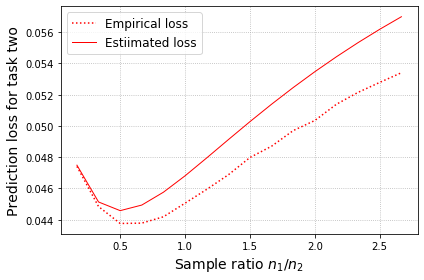

In [9]:
te_beta_t = te_target(X1, X2, beta_s, beta_t, 0)

plt.figure(figsize=(6,4))

cut = 4

x_thy = np.array(provable_neg[0]) / c2
y_thy = 100*(te_beta_t-np.array(provable_neg[1]) )
x_thy = x_thy[: len(x_thy) - cut]
y_thy = y_thy[: len(y_thy) - cut]
x_emp = np.array(c1_list) / c2
y_emp = 100*(te_beta_t-np.array(te_mtl_list) )
x_emp = x_emp[: len(x_emp) - cut]
y_emp = y_emp[: len(y_emp) - cut]


plt.plot(np.array(c1_list) / c2, te_mtl_list, ls = ':', c='r', label='Empirical loss')
plt.plot(np.array(c1_list) / c2, estimate_list, c='r', lw=1, label='Estiimated loss')


#plt.scatter(np.array(provable_pos[0]) / c2, 1.5* 100*(te_beta_t-np.array(provable_pos[1]) ), marker='+', s=300, lw=4, c='r', label='Predicted positive')
#plt.scatter(x_thy, 1.5 * y_thy, marker='_', s=300, lw=4, c='orange', label='Predicted negative')
#plt.scatter(np.array(unknown[0]) / c2, 1.5 * 100*(te_beta_t-np.array(unknown[1]) ), marker='o', s=20, lw=4, c='y')
#plt.plot(x_emp, 1.5 * y_emp, c='k', lw=3, ls=':', label='Empirical curve')

#plt.plot(np.arange(0,900,50), [te_beta_t] * 18, lw=3, c='k', ls='dotted', label='Single-task learning')

plt.xlabel(r'Sample ratio $n_1 / n_2$', fontsize=14)
plt.ylabel('Prediction loss for task two', fontsize=14)

#plt.xticks(np.arange(0.2, 0.8, 0.2), fontsize=14)
#plt.yticks(np.arange(0.03, 0.045, 0.005), fontsize=14)
#plt.xlim([0.1, 0.7])
#plt.ylim([0.028, 0.033])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('sample_ratio.eps')

## Plot the effect of source task data size

In [10]:
c1 = 50

a = 1 / (1 - 1.0/ math.sqrt(c1))**4
b = 1 / (1 + 1.0/ math.sqrt(c1))**4
print(a, b)

1.8402620635216012 0.5891366269102105


In [11]:
d = 0.02
sigma = 4
p = 200
c1 = 50
c2 = 500

print(d**2 / (sigma**2 / (p * (c2 - 1))))

2.495


In [12]:
te_beta_t-np.array(te_mtl_list)

array([0.00613384, 0.00870212, 0.00978285, 0.00976146, 0.00935525,
       0.00848538, 0.00760202, 0.00666982, 0.00556307, 0.00483998,
       0.00384086, 0.00319454, 0.00215469, 0.0013955 , 0.00075774,
       0.00014104])

In [13]:
for a, b in zip(np.array(provable_pos[0]) / c2, 1.5* 100*(te_beta_t-np.array(provable_pos[1]) )):
    print(a, b)
print()

for a, b in zip(x_thy, 1.5* y_thy):
    print(a, b)
print()

for a, b in zip(np.array(unknown[0]) / c2, 1.5* 100*(te_beta_t-np.array(unknown[1]) )):
    print(a, b)

0.1 0.9200755678842935
0.2 1.3053183118068565
0.3 1.4674267883775447
0.4 1.4642193124992369
0.5 1.403287390824435
0.6 1.272806710009279
0.7 1.1403027273007578


0.8 1.0004737486865305
0.9 0.8344607531317723
1.0 0.7259974621549468
1.1 0.5761293520788392
1.2 0.4791803904422076
1.3 0.3232029471739433
1.4 0.20932452012882607
1.5 0.11366043697229739
1.6 0.02115610798477663
